In [1]:
#%matplotlib widget
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [33]:
import sys
from pathlib import Path
import torch
import numpy as np
import tqdm

from ripser import ripser
from persim import plot_diagrams

# Plotting
import matplotlib
from matplotlib import pyplot as plt
plt.style.use('../bioAI.mplstyle')

'''
CUSTOM PACKAGES
'''
# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None

from Models import SorscherRNN
from Experiment import Experiment
from datahandling import Dataset, MESampler
from plotting_functions import *
from synthetic_grid_cells import *
from methods import *
from stats import *

In [3]:
#base_path = Path("/storA/GridCells/")
base_path = "/mnt/WD12TB-HDD"
experiment = Experiment(name="gg-3ME", base_path=base_path)
experiment.setup()

module_indices = np.load(f"{experiment.paths['experiment']}/module_indices.npz")
print(module_indices.files)
module_indices = module_indices['C5_from_env_2']

ncells = len(module_indices)

# percentile is chosen manually to get 315 cells.
gs_masks = grid_score_masks(experiment, percentile=0.547, mode="intersection")
gs_idxs = np.where(gs_masks)[0]

Experiment <gg-3ME> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.
['C0_from_env_0', 'C1_from_env_1', 'C5_from_env_2']


In [4]:
# detach experiment specifics
params = experiment.params
environments = experiment.environments
agents = experiment.agents
pc_ensembles = experiment.pc_ensembles
paths = experiment.paths

num_workers = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device=}")

# Initialise data loading
num_samples = params['nsteps'] * params['batch_size'] # * params['nepochs']
dataset = Dataset(agents = agents, pc_ensembles = pc_ensembles, num_samples = num_samples, seq_len=20)#, **params)
datasampler = eval(params['sampler'])(num_environments = len(environments), num_samples = num_samples, \
                                      num_epochs = params['nepochs'])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'], sampler = datasampler, num_workers=num_workers)

device=device(type='cuda')


In [5]:
def load_model(experiment):
    # load weights
    checkpoint_filenames = filenames(experiment.paths['checkpoints'])
    # load model latest (wrt. #epochs trained)
    print(f"Loading model at epoch = {checkpoint_filenames[-1]}", experiment.paths['checkpoints'] / checkpoint_filenames[-1])
    checkpoint = torch.load(experiment.paths['checkpoints'] / checkpoint_filenames[-1])
    # instantiate trained model this time
    model = SorscherRNN(experiment.pc_ensembles, Ng=experiment.params['Ng'], Np=experiment.params['Np'])
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

model = load_model(experiment)

Loading model at epoch = 02999 /mnt/WD12TB-HDD/data/emergent-grid-cells/gg-3ME/checkpoints/02999


In [6]:
def smooth_ratemaps(model, prune_idxs, module_indices, **kwargs):
    model.prune_mask = prune_idxs
    ratemaps = compute_ratemaps(model=model.g, idxs=module_indices, **kwargs).statistic
    from astropy.convolution import Gaussian2DKernel, convolve
    kernel = Gaussian2DKernel(x_stddev=1.0)
    smooth_ratemaps = convolve(ratemaps, kernel.array[None], boundary='extend')
    return smooth_ratemaps

In [36]:
panesize = set_size(width=345, mode='tall')
figsize = np.array((panesize[0]/3,panesize[1]*2/6))

plt.rcParams["figure.autolayout"] = False
plt.rcParams["figure.subplot.wspace"] = 0
plt.rcParams["figure.subplot.hspace"] = 0
plt.rcParams["figure.subplot.left"] = 0
plt.rcParams["figure.subplot.right"] = 1
plt.rcParams["figure.subplot.bottom"] = 0
plt.rcParams["figure.subplot.top"] = 1
plt.rcParams["figure.autolayout"] = True

In [8]:
pca_fits, umap_fits = [], []
res = np.array([64,64])
num_trajectories=3000

# set seed (best practice is to instantiate and use an rng)
rng = np.random.default_rng(2022)
idxs_perm = rng.choice(range(params["Ng"]), size=params["Ng"], replace=False)

In [9]:
prune_idxs = idxs_perm[:20]
ratemaps = smooth_ratemaps(model,prune_idxs=prune_idxs,module_indices=module_indices,dataset=dataset,num_trajectories=num_trajectories,res=res)
g = ratemaps.reshape(len(ratemaps),-1).T

pca_fit, umap_fit = PCA_UMAP(g)
pca_fits.append(pca_fit)
umap_fits.append(umap_fit)

100%|███████████████████████████████████████| 3000/3000 [02:41<00:00, 18.60it/s]


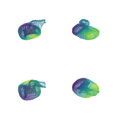

In [37]:
fig,axs = scatter3d(umap_fits[0], pca_fits[0][:,0],ncols=2,nrows=2,s=0.005,alpha=0.8,azim_elev_title=False, figsize=figsize)
fig.savefig(experiment.paths['experiment'] / f'plots/20-random-pruning')

In [11]:
prune_idxs = idxs_perm[:50]
ratemaps = smooth_ratemaps(model,prune_idxs=prune_idxs,module_indices=module_indices,dataset=dataset,num_trajectories=num_trajectories,res=res)
g = ratemaps.reshape(len(ratemaps),-1).T

pca_fit, umap_fit = PCA_UMAP(g)
pca_fits.append(pca_fit)
umap_fits.append(umap_fit)

100%|███████████████████████████████████████| 3000/3000 [02:46<00:00, 18.06it/s]


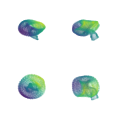

In [38]:
fig,axs = scatter3d(umap_fits[1], pca_fits[1][:,0],ncols=2,nrows=2,s=0.005,alpha=0.8,azim_elev_title=False, figsize=figsize)
fig.savefig(experiment.paths['experiment'] / f'plots/50-random-pruning')

In [13]:
prune_idxs = idxs_perm[:100]
ratemaps = smooth_ratemaps(model,prune_idxs=prune_idxs,module_indices=module_indices,dataset=dataset,num_trajectories=num_trajectories,res=res)
g = ratemaps.reshape(len(ratemaps),-1).T

pca_fit, umap_fit = PCA_UMAP(g)
pca_fits.append(pca_fit)
umap_fits.append(umap_fit)

100%|███████████████████████████████████████| 3000/3000 [02:33<00:00, 19.58it/s]


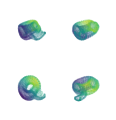

In [39]:
fig,axs = scatter3d(umap_fits[2], pca_fits[2][:,0],ncols=2,nrows=2,s=0.005,alpha=0.8,azim_elev_title=False, figsize=figsize)
fig.savefig(experiment.paths['experiment'] / f'plots/100-random-pruning')

In [15]:
prune_idxs = idxs_perm[:200]
ratemaps = smooth_ratemaps(model,prune_idxs=prune_idxs,module_indices=module_indices,dataset=dataset,num_trajectories=num_trajectories,res=res)
g = ratemaps.reshape(len(ratemaps),-1).T

pca_fit, umap_fit = PCA_UMAP(g)
pca_fits.append(pca_fit)
umap_fits.append(umap_fit)

100%|███████████████████████████████████████| 3000/3000 [02:31<00:00, 19.86it/s]


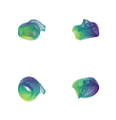

In [40]:
fig,axs = scatter3d(umap_fits[3], pca_fits[3][:,0],ncols=2,nrows=2,s=0.005,alpha=0.8,azim_elev_title=False, figsize=figsize)
fig.savefig(experiment.paths['experiment'] / f'plots/200-random-pruning')

In [17]:
torch.sum(model.prune_mask[1]), np.prod(np.array(model.prune_mask[1].shape))

(tensor(15958016.), 16777216)

(array([40., 32., 23., 18., 12.,  8.,  2.,  0.,  0.,  1.]),
 array([0.00032237, 0.01845417, 0.03658597, 0.05471777, 0.07284957,
        0.09098136, 0.10911316, 0.12724496, 0.14537676, 0.16350856,
        0.18164036]),
 <BarContainer object of 10 artists>)

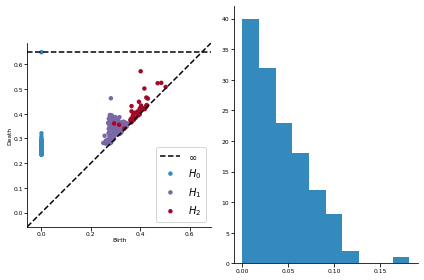

In [18]:
fig,axs = plt.subplots(ncols=2)
#dgms = ripser(g,maxdim=2,n_perm=150)['dgms']
dgms = ripser(pca_fits[0],maxdim=2,n_perm=150)['dgms']
plot_diagrams(dgms, show=False, ax=axs[0])
axs[1].hist(dgms[1][:,1] - dgms[1][:,0])